In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/'
import preprocess

!pip install scikit-plot
import scikitplot as skplt

Mounted at /content/gdrive
/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pandas as pd 
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import matplotlib.pyplot as plt

In [6]:
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/authority/data/'

df_ = preprocess.get_data(file='training_auth_50k.csv', drop = True, columns_to_drop = ['Unnamed: 0']) 
df_ = df_.sample(frac = 1).reset_index(drop = True)
df_

/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/authority/data


,ad,auth
0,httpwwwthinkinchinaasiaphilanthropyinchina the...,1
1,justin trudeau says anything to get elected\nw...,1
2,diversity of opinion at a university well then...,1
3,as a bipartisan problem solver i’ll work to so...,0
4,president trump is tweets have gone from embar...,1
...,...,...
49995,american owned quick shipping our shirts screa...,0
49996,people have asked me what i will do as supervi...,1
49997,for women refugees forced to flee when violenc...,0
49998,zoogoers in china threw bricks at a kangaroo j...,0


In [7]:
df_['ad'] = df_['ad'].str.replace("http.*","", regex = True)
df_['ad'] = df_['ad'].str.replace("bitly.*","", regex = True)
df_['ad'] = df_['ad'].str.replace("sbit.*","", regex = True)
df_['ad'] = df_['ad'].str.replace("sbuf.*","", regex = True)
df_['ad'] = df_['ad'].str.replace("youtube.*","", regex = True)
df_['ad'] = df_['ad'].str.replace("www.*","", regex = True)
df_['ad'] = df_['ad'].str.replace('\d+', '', regex = True)
df_

,ad,auth
0,,1
1,justin trudeau says anything to get elected\nw...,1
2,diversity of opinion at a university well then...,1
3,as a bipartisan problem solver i’ll work to so...,0
4,president trump is tweets have gone from embar...,1
...,...,...
49995,american owned quick shipping our shirts screa...,0
49996,people have asked me what i will do as supervi...,1
49997,for women refugees forced to flee when violenc...,0
49998,zoogoers in china threw bricks at a kangaroo j...,0


In [8]:
df_.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df_

,ad,auth
0,,1
1,justin trudeau says anything to get elected\nw...,1
2,diversity of opinion at a university well then...,1
3,as a bipartisan problem solver i’ll work to so...,0
4,president trump is tweets have gone from embar...,1
...,...,...
49995,american owned quick shipping our shirts screa...,0
49996,people have asked me what i will do as supervi...,1
49997,for women refugees forced to flee when violenc...,0
49998,zoogoers in china threw bricks at a kangaroo j...,0


In [9]:
import re 
# Functions for removing contractions 
contraction_dict = {"we're": "we are","ain't": "are not","'s":" is","aren't": "are not", "won't": "would not", "don't": "do not", "isn't": "is not", "it's" : "it is"}
def expand_contractions(data,contractions_dict = contraction_dict):
  '''
    Expanding Contractions
    Arguments:
      data: textual dataset 
      contractions_dict : dictionanary containing the contractions and their replacements 
    Returns :
      clean_data : textual dataset where contractions are expanded
  '''
  # Regular expression for finding contractions
  contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
  def replace(match):
      return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, data)

In [10]:
import string 

df_['ad'] = df_['ad'].str.strip().str.lower() 

# Expand contractions 
df_['ad'] = df_['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df_['ad'] =  df_['ad'].str.translate(str.maketrans('','',string.punctuation))

df_

,ad,auth
0,,1
1,justin trudeau says anything to get elected\nw...,1
2,diversity of opinion at a university well then...,1
3,as a bipartisan problem solver i’ll work to so...,0
4,president trump is tweets have gone from embar...,1
...,...,...
49995,american owned quick shipping our shirts screa...,0
49996,people have asked me what i will do as supervi...,1
49997,for women refugees forced to flee when violenc...,0
49998,zoogoers in china threw bricks at a kangaroo j...,0


In [11]:
df_.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df_

,ad,auth
0,,1
1,justin trudeau says anything to get elected\nw...,1
2,diversity of opinion at a university well then...,1
3,as a bipartisan problem solver i’ll work to so...,0
4,president trump is tweets have gone from embar...,1
...,...,...
49995,american owned quick shipping our shirts screa...,0
49996,people have asked me what i will do as supervi...,1
49997,for women refugees forced to flee when violenc...,0
49998,zoogoers in china threw bricks at a kangaroo j...,0


In [12]:
train, test = preprocess.eval_train_split(data = df_['ad'], labels = df_['auth'], test_size =0.33, validation=False)
X_train, y_train, X_test, y_test = train[0], train[1], test[0], test[1]


**Count vectorizer**
---



In [13]:
# Use term frequency to represent documents
tf_vectorizer = CountVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_tf,y_train)

RandomForestClassifier()

accuracy:   0.912
                  precision    recall  f1-score   support

non_social_norms       0.91      0.91      0.91      8245
    social_norms       0.91      0.91      0.91      8146

        accuracy                           0.91     16391
       macro avg       0.91      0.91      0.91     16391
    weighted avg       0.91      0.91      0.91     16391

confusion matrix:
[[7525  720]
 [ 724 7422]]



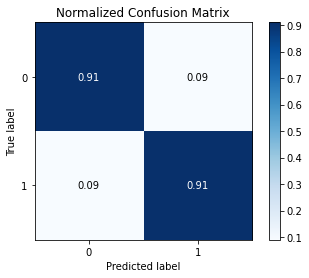

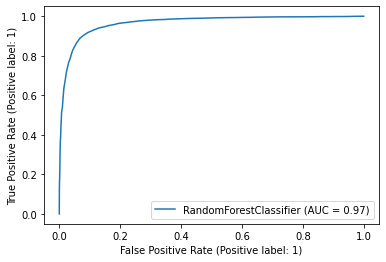

In [17]:
# make predictions
y_pred = clf.predict(X_test_tf)

# model performance
score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_test, y_pred, target_names=['non_social_norms', 'social_norms']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(clf, X_test_tf, y_test)

In [18]:
df_val = pd.read_csv('test_auth_18k.csv')
df_val=df_val.sample(frac=1)
import string 

df_val['ad'] = df_val['ad'].str.strip().str.lower() 

# Expand contractions 
df_val['ad'] = df_val['ad'].apply(lambda x:expand_contractions(x))
# Remove ponctuation 
df_val['ad'] =  df_val['ad'].str.translate(str.maketrans('','',string.punctuation))




In [19]:
df_val.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df_val

,Unnamed: 0,ad,auth
5885,2595,it’s not flashy or glamorous but some of the m...,1
10675,3623,louisville is facing challenges we could hardl...,0
2515,59457,how did the empire state building increase ene...,1
6934,8550,susan collins betrayed her constituents when s...,1
4230,2850,if you want to take back the senate and retire...,1
...,...,...,...
12407,4894,rep madeleine dean took action to protect medi...,0
14452,37643,as a nonprofit organization a big part of our ...,0
17214,22488,tonia khouri villa is opponent has said “this ...,0
9924,59283,big news a new poll has kyrsten sinema out to ...,0


In [20]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['auth']

accuracy:   0.911
              precision    recall  f1-score   support

     no-auth       0.91      0.91      0.91      8649
        auth       0.91      0.91      0.91      8650

    accuracy                           0.91     17299
   macro avg       0.91      0.91      0.91     17299
weighted avg       0.91      0.91      0.91     17299

confusion matrix:
[[7869  780]
 [ 752 7898]]



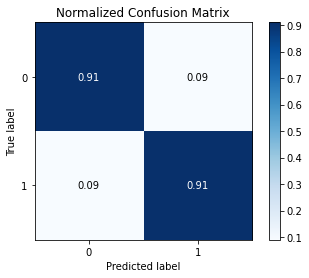

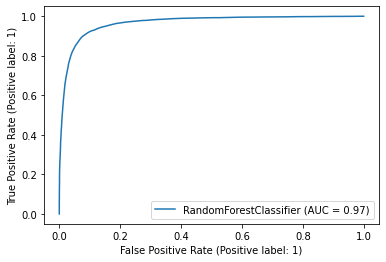

In [21]:
y_pred = clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-auth', 'auth']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val)

In [22]:
df_val = pd.read_csv('sample_auth.csv')
df_val=df_val.sample(frac=1)
df_val

,ad,authority
77,"""Let us not miss this opportunity.""\nPrince Al...",1
74,9-year-old Danylo is not only battling cancer ...,0
21,LIVE: Women leaders discuss how to #Accelerat...,1
95,More and more data indicate that women are und...,1
82,"""Bringing hope and restoration to a community ...",0
...,...,...
75,The number of out-of-school children in South ...,0
25,Do you want to know how fashion students would...,1
76,"While we’re all wearing masks, please remember...",0
106,Is your city ready to take on the City Cancer ...,0


In [23]:
import string 
df_val['ad'] = df_val['ad'].str.strip().str.lower() 

# Expand contractions 
df_val['ad'] = df_val['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df_val['ad'] =  df_val['ad'].str.translate(str.maketrans('','',string.punctuation))

df_val

,ad,authority
77,let us not miss this opportunity\nprince alber...,1
74,9yearold danylo is not only battling cancer bu...,0
21,live women leaders discuss how to accelerateeq...,1
95,more and more data indicate that women are und...,1
82,bringing hope and restoration to a community i...,0
...,...,...
75,the number of outofschool children in south af...,0
25,do you want to know how fashion students would...,1
76,while we’re all wearing masks please remember ...,0
106,is your city ready to take on the city cancer ...,0


accuracy:   0.731
              precision    recall  f1-score   support

     no-auth       0.69      0.83      0.76        54
        auth       0.79      0.63      0.70        54

    accuracy                           0.73       108
   macro avg       0.74      0.73      0.73       108
weighted avg       0.74      0.73      0.73       108

confusion matrix:
[[45  9]
 [20 34]]



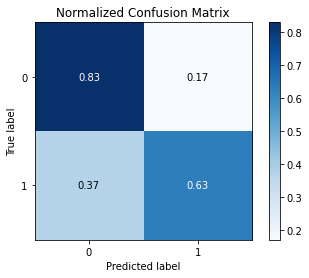

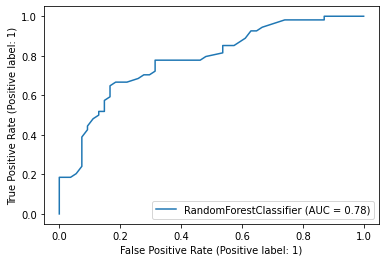

In [24]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['authority']

y_pred = clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-auth', 'auth']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val)